# Getting data ready

Getting patient ct lung scans. Each patient has hundreds of slices, each one of them being 2d scans of their lungs. In this notebook we get the top three slices of each patient that has been marked with having the biggest detected nodules inside their lungs. We then treat that data to segment only the lungs on each scan, and make an image mask that contains the location of the biggest node detected in their respective scan. After all of that, we build a set of lung images and label images.

This code was extracted and slightly modified from the [Data Science Bowl 2017 contest](https://www.kaggle.com/c/data-science-bowl-2017#description) getting started tutorial. The source code can be found [here](https://github.com/booz-allen-hamilton/DSB3Tutorial).

In [2]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd

In [3]:
input_path = "../sets/"
output_path = "../outs/"

file_list=glob(input_path+"*.mhd")

In [4]:
# Helper function to get rows in data frame associated with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)

In [5]:
def make_mask(center,diam,z,width,height,spacing,origin):
    
    '''
    Center : centers of circles px -- list of coordinates x,y,z
    diam : diameters of circles px -- diameter
    widthXheight : pixel dim of image
    spacing = mm/px conversion rate np array x,y,z
    origin = x,y,z mm np.array
    z = z position of slice in world coordinates mm
    '''
    
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [6]:
def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    #matrix = matrix-m_min  # Isto e um bug no codigo original.
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

## 1. Retrieving the images and saving top 3 slices and masks 

In [7]:
# The locations of the nodes
df_node = pd.read_csv("../annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)

df_node = df_node.dropna()

# Looping over the image files
fcount = 0

fcount = 0
for img_file in file_list:
    print ("Getting mask for image file %s" % img_file.replace(input_path,""))
    mini_df = df_node[df_node["file"]==img_file] #constroi um mini-df com infos de nodulos pra cada file
    if len(mini_df)>0:    # pulas as slices sem nodulos 
        biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # pega dados do maior nodulo
        node_x = mini_df["coordX"].values[biggest_node]
        node_y = mini_df["coordY"].values[biggest_node]
        node_z = mini_df["coordZ"].values[biggest_node]
        diam = mini_df["diameter_mm"].values[biggest_node]
        #
        # extracting image
        #
        itk_img = sitk.ReadImage(img_file) #pega imagem
        img_array = sitk.GetArrayFromImage(itk_img) #indexes are z,y,x --pega dados da imagem
        num_z,height,width = img_array.shape        #heightXwidth constitute the transverse plane
        imgs = np.ndarray([3,height,width],dtype=np.uint16)
        masks = np.ndarray([3,height,width],dtype=np.uint8)
        center = np.array([node_x,node_y,node_z])  #centro do nodulo
        origin = np.array(itk_img.GetOrigin()) #x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())# spacing of voxels in world coor. (mm) --transforma dimensao da img em mm
        v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space --encaixa local do nodulo na img
        #
        # for each slice in the image, convert the image data to the uint16 range
        # and generate a binary mask for the nodule location
        #
        i = 0
        for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
            mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
            masks[i] = mask
            imgs[i] = matrix2int16(img_array[i_z])
            i+=1
        #

        np.save(output_path+"images_%d.npy" % (fcount) ,imgs)
        np.save(output_path+"masks_%d.npy" % (fcount) ,masks)
        fcount+=1

Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd
Getting mask for image file 1.

Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd


## 2. Creating the lung masks

In [8]:
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

In [9]:
file_list=glob(output_path+ "images_*.npy")

for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std

        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean

        #plt.hist(img.flatten(),bins=200)
        

        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        valid_values = np.reshape(middle,[np.prod(middle.shape),1])
        kmeans = KMeans(n_clusters=2).fit(valid_values)
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        labels = measure.label(dilation)

        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)

        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        
        imgs_to_process[i] = mask 
        
    np.save(img_file.replace("images","lungmask"),imgs_to_process)

on image ../outs/images_23.npy
on image ../outs/images_63.npy
on image ../outs/images_30.npy
on image ../outs/images_57.npy
on image ../outs/images_56.npy
on image ../outs/images_45.npy
on image ../outs/images_40.npy
on image ../outs/images_10.npy
on image ../outs/images_31.npy
on image ../outs/images_26.npy
on image ../outs/images_21.npy
on image ../outs/images_18.npy
on image ../outs/images_28.npy
on image ../outs/images_58.npy
on image ../outs/images_48.npy
on image ../outs/images_32.npy
on image ../outs/images_36.npy
on image ../outs/images_4.npy
on image ../outs/images_5.npy
on image ../outs/images_14.npy
on image ../outs/images_50.npy
on image ../outs/images_15.npy
on image ../outs/images_29.npy
on image ../outs/images_52.npy
on image ../outs/images_13.npy
on image ../outs/images_44.npy
on image ../outs/images_22.npy
on image ../outs/images_66.npy
on image ../outs/images_12.npy
on image ../outs/images_11.npy
on image ../outs/images_37.npy
on image ../outs/images_62.npy
on image .

## 3. Creating the training and test datasets

In [10]:
file_list=glob(output_path+"lungmask_*.npy")


out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks


for fname in file_list:
    
    print("working on file ", fname)
    
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img = mask*img         # apply lung mask

        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color        
        img = img - new_mean
        img = img / new_std
        
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)        
        
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            #print(B)
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col - min_col
        height = max_row - min_row
        
        if width > height:
            max_row = min_row + width
        else:
            max_col = min_col + height
        
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)        

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(output_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(output_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(output_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(output_path+"testMasks.npy",final_masks[rand_i[:test_i]])


working on file  ../outs/lungmask_6.npy
working on file  ../outs/lungmask_40.npy
working on file  ../outs/lungmask_60.npy
working on file  ../outs/lungmask_17.npy


/home/lucas/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


working on file  ../outs/lungmask_13.npy
working on file  ../outs/lungmask_19.npy
working on file  ../outs/lungmask_16.npy
working on file  ../outs/lungmask_37.npy
working on file  ../outs/lungmask_54.npy
working on file  ../outs/lungmask_30.npy
working on file  ../outs/lungmask_31.npy
working on file  ../outs/lungmask_24.npy
working on file  ../outs/lungmask_55.npy
working on file  ../outs/lungmask_25.npy
working on file  ../outs/lungmask_5.npy
working on file  ../outs/lungmask_12.npy
working on file  ../outs/lungmask_22.npy
working on file  ../outs/lungmask_56.npy
working on file  ../outs/lungmask_29.npy
working on file  ../outs/lungmask_20.npy
working on file  ../outs/lungmask_23.npy
working on file  ../outs/lungmask_0.npy
working on file  ../outs/lungmask_1.npy
working on file  ../outs/lungmask_47.npy
working on file  ../outs/lungmask_8.npy
working on file  ../outs/lungmask_42.npy
working on file  ../outs/lungmask_34.npy
working on file  ../outs/lungmask_3.npy
working on file  ../o

image 0


<IPython.core.display.Javascript object>


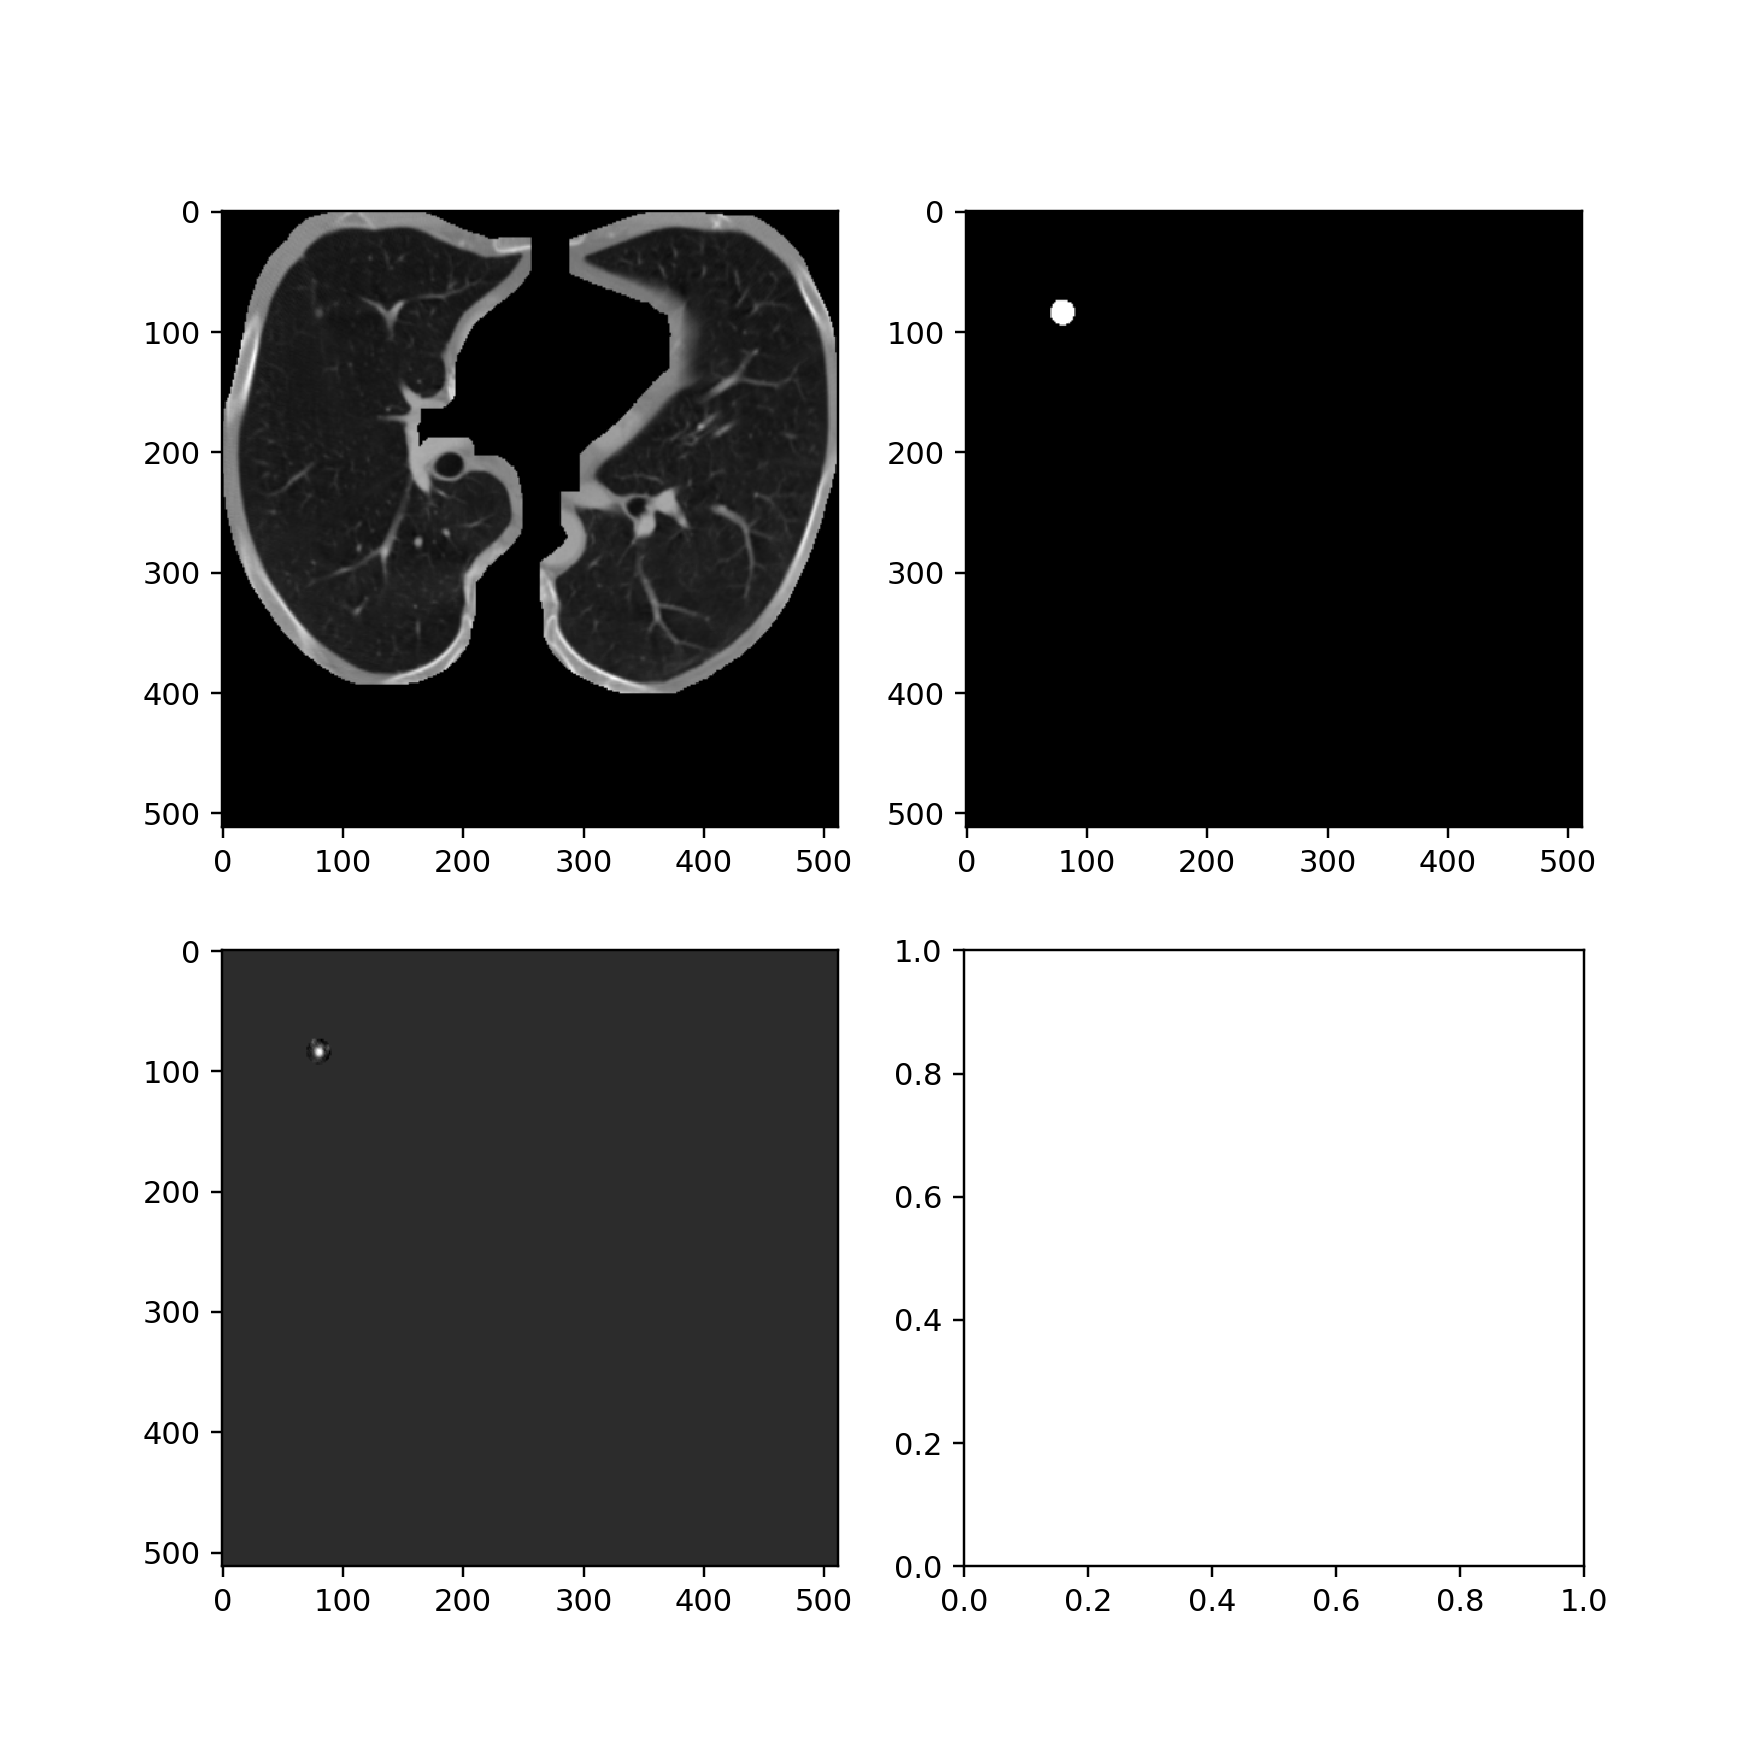

image 1


<IPython.core.display.Javascript object>


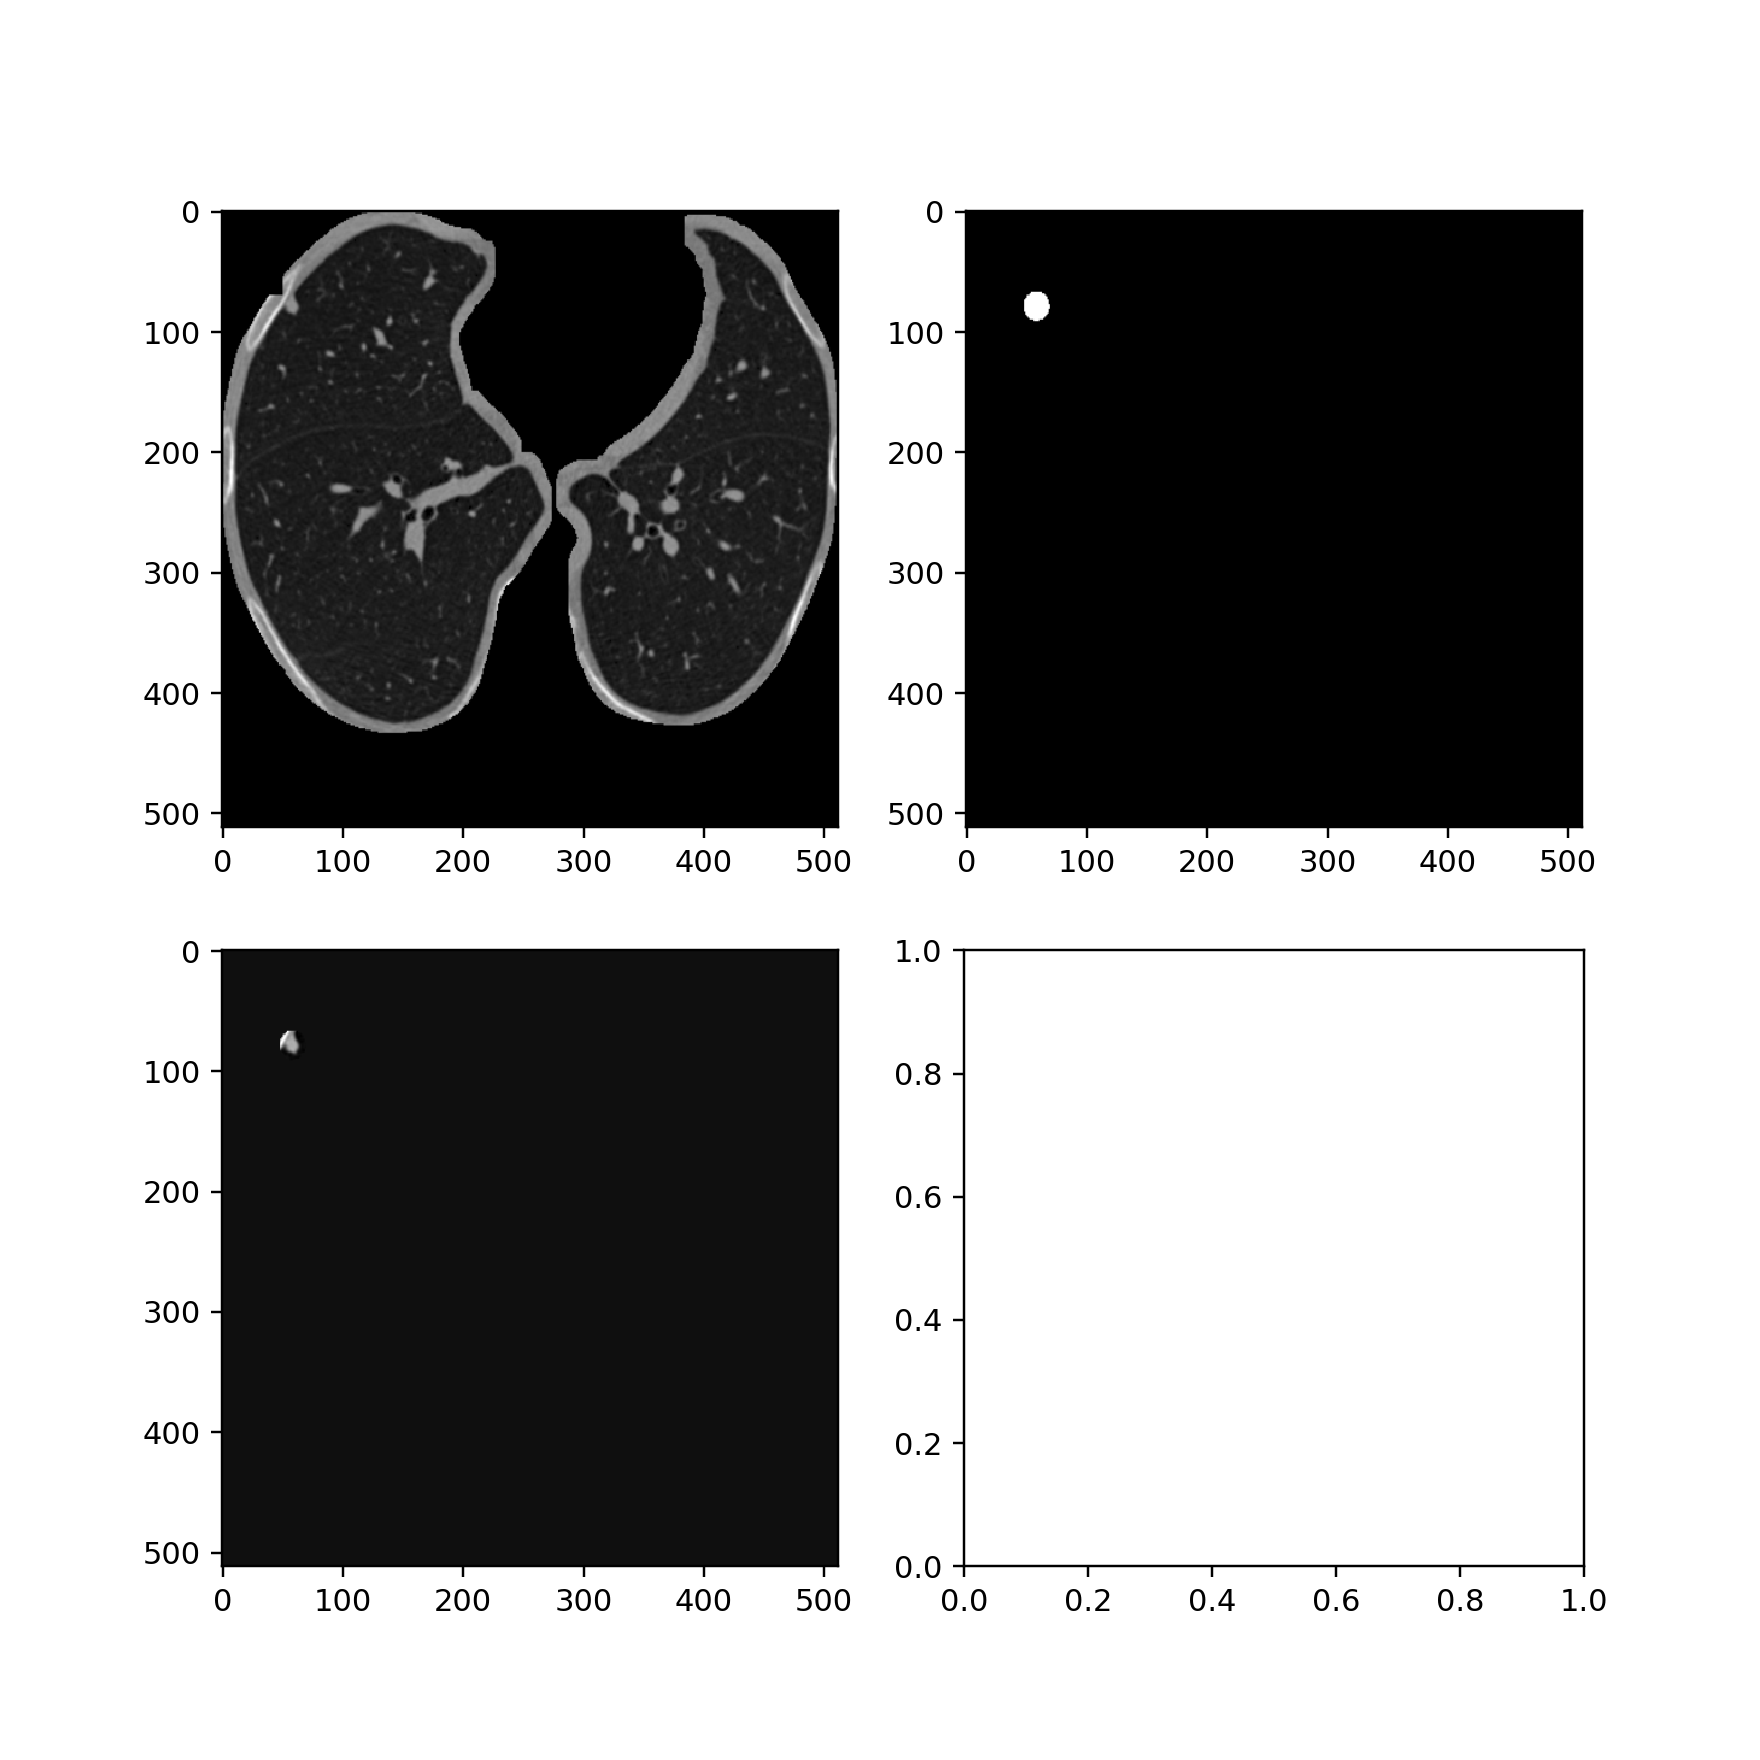

image 2


<IPython.core.display.Javascript object>


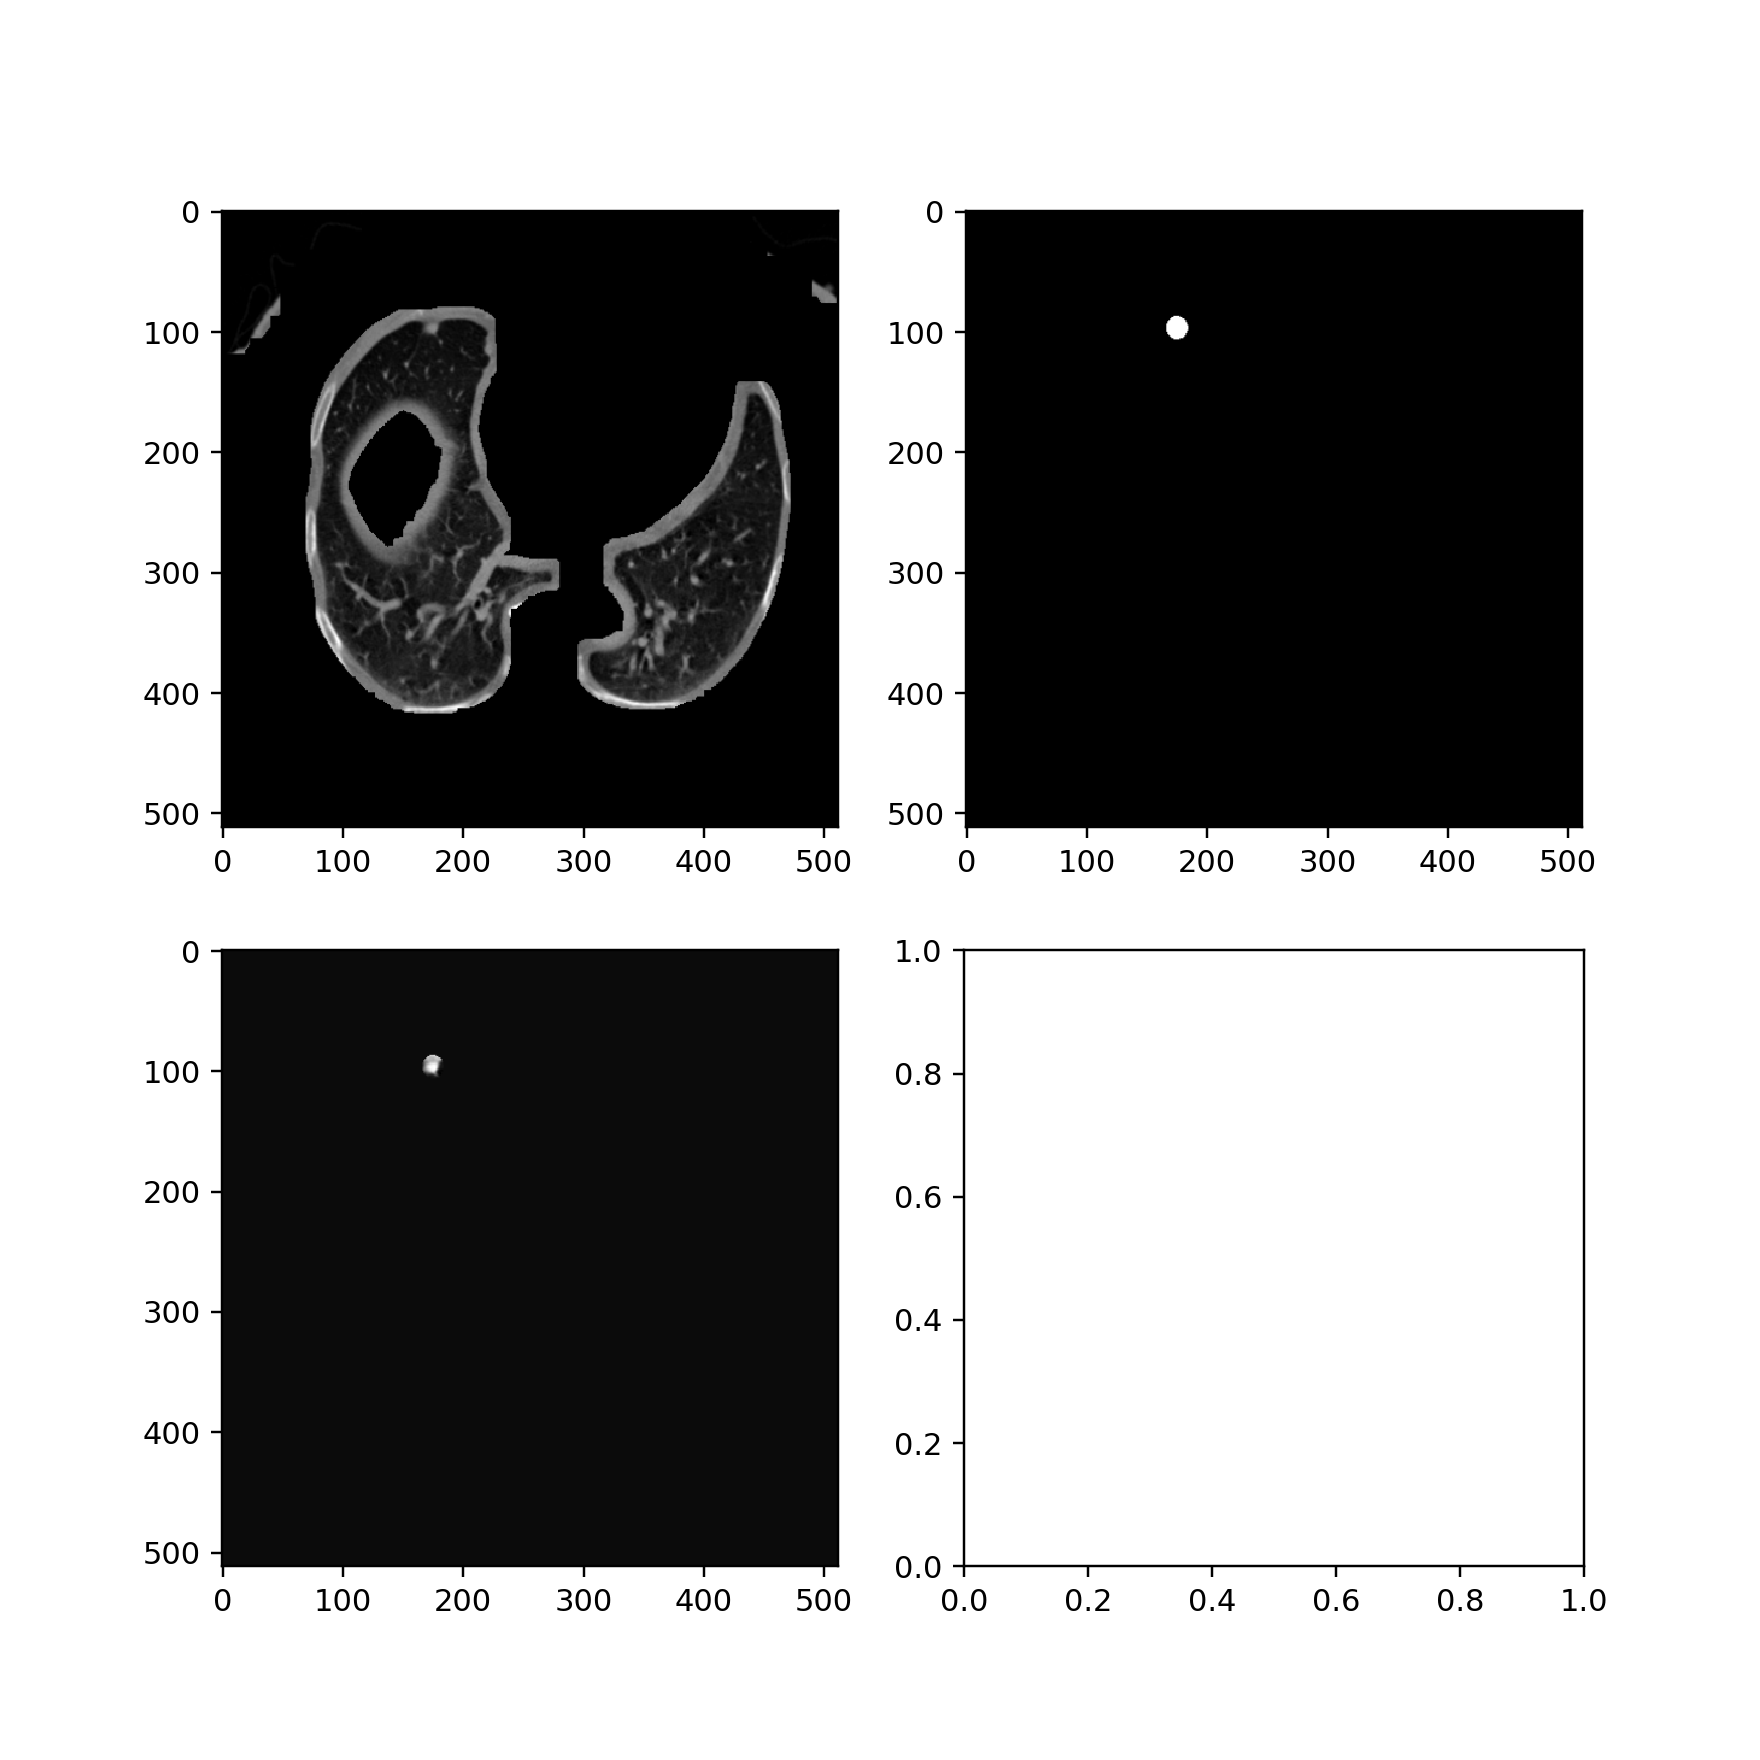

In [11]:
import matplotlib.pyplot as plt


%matplotlib notebook



img_filename = '../outs/testImages.npy'
mask_filename = '../outs/testMasks.npy'

imgs = np.load(img_filename)
masks = np.load(mask_filename)

for i in range(3):
    print ("image %d" % i)
    
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    
    ax[0,0].imshow(imgs[i,0],cmap='gray') #slice tomografia
    ax[0,1].imshow(masks[i,0],cmap='gray') #mascara nodulo annotations.csv correspondente
    ax[1,0].imshow(imgs[i,0]*masks[i,0],cmap='gray') #mascara aplicada na slice
    
    plt.show()